In [1]:
import csv
import random
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from scipy.misc import imread, imsave, imresize
from skimage import exposure
import warnings 

In [2]:
def preprocess(X):
    '''
    - convert images to grayscale, 
    - scale from [0, 255] to [0, 1] range, 
    - use localized histogram equalization as images differ 
      in brightness and contrast significantly
    ADAPTED FROM: http://navoshta.com/traffic-signs-classification/
    '''

    #Convert to grayscale, e.g. single channel Y
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]

    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
    
    #adjust histogram
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i]) 
            
    return X

def reshape(x): # Add a single grayscale channel
  return x.reshape(x.shape + (1,))

In [3]:
######################################
##   LOAD AND PREPROCESS DATA       #
####################################

#''' 
#The pickled data is a dictionary with 4 key/value pairs
#
#features: the images pixel values, (width, height, channels)
#labels: the label of the traffic sign
#sizes: the original width and height of the image, (width, height)
#coords: coordinates of a bounding box around the sign in the image, 
#        (x1, y1, x2, y2). 
#        Based the original image (not the resized version).
#'''

In [4]:
######################
#!!   EDIT ME!   !! #
####################

class_name_file = './signnames.csv'
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

training_preprocessed_file = "data/X_train_preprocessed.p"
validation_preprocessed_file = "data/X_valid_preprocessed.p"
testing_preprocessed_file = "data/X_test_preprocessed.p" 

In [5]:
# LOAD DATA SETS TO MEMORY

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
# Preprocess the data to improve feature extraction... This might take a while..

X_preprocessed = preprocess(X_train)
X_train_preprocessed = reshape(X_preprocessed)
print("training set preprocessing complete!", X_train_preprocessed.shape)

X_valid_preprocessed = preprocess(X_valid)
X_valid_preprocessed = reshape(X_valid_preprocessed)
print("cross validation set preprocessing complete!", X_valid_preprocessed.shape)

X_test_preprocessed = preprocess(X_test)
X_test_preprocessed = reshape(X_test_preprocessed)
print("test set preprocessing complete!", X_test_preprocessed.shape)

training set preprocessing complete! (34799, 32, 32, 1)
cross validation set preprocessing complete! (4410, 32, 32, 1)
test set preprocessing complete! (12630, 32, 32, 1)


In [7]:
# Save the preprocessed data set, so we don't have to preprocess it everytime 

pickle.dump(X_train_preprocessed, open(training_preprocessed_file, "wb" ))
pickle.dump(X_valid_preprocessed, open(validation_preprocessed_file, "wb" ))
pickle.dump(X_test_preprocessed, open(testing_preprocessed_file, "wb" ))

In [6]:
# If the preprocessed data exists, we can just open them up
# no need to preprocess them everytime  

with open(training_preprocessed_file, mode='rb') as f:
    X_train_preprocessed = pickle.load(f)
with open(validation_preprocessed_file, mode='rb') as f:
    X_valid_preprocessed = pickle.load(f)
with open(testing_preprocessed_file, mode='rb') as f:
    X_test_preprocessed = pickle.load(f)

In [7]:
######################################
#          DATA EXPLORATION         #
####################################

In [8]:
# We can see some basic statistics about the data sets here 

n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_classes = len(np.unique(y_test))

number_of_images, image_width, image_height, number_of_color_channels = X_train.shape
image_shape = image_width, image_height, number_of_color_channels

print()
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_valid :", X_valid.shape)
print("y_valid :", y_valid.shape)
print("X_test  :", X_test.shape)
print("y_test  :", y_test.shape)

print()
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


X_train : (34799, 32, 32, 3)
y_train : (34799,)
X_valid : (4410, 32, 32, 3)
y_valid : (4410,)
X_test  : (12630, 32, 32, 3)
y_test  : (12630,)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [9]:
# Let's count how many samples per classification the training set has
# We can also map the label value representation to actual human label from CSV file
# in essence: y: 10 is the STOP sign
# Notice that the data set is not shuffled, images with the same class are adjacent to each
# other in the list. So a running count is useful to to know what range of position 
# an images of the same class occupies. 

classes_lineup = []
count_per_class = [0]*n_classes
running_counts = [0]*n_classes
class_names = []

for i in range(0, len(y_train)):
    if y_train[i] not in classes_lineup:
        classes_lineup.append(y_train[i])
    count_per_class[y_train[i]]+=1

count_before = 0
for n in classes_lineup:
    running_counts[n] = count_per_class[n] + count_before
    count_before = running_counts[n]
    
with open(class_name_file) as _f:
    rows = csv.reader(_f, delimiter=',')
    next(rows, None)
    for i, row in enumerate(rows):
        assert(i==int(row[0]))
        class_names.append(row[1]) 

In [10]:
def show_images(X, end, total, images_per_row = 30, images_per_col = 15,
                H = 20, W = 1, its_gray = False):    
    number_of_images = images_per_row * images_per_col
    figure, axis = plt.subplots(images_per_col, images_per_row, figsize=(H, W))
    figure.subplots_adjust(hspace = .2, wspace=.001)
    axis = axis.ravel()
    
    for i in range(number_of_images):
        index = random.randint(end - total, end)
        image = X[index]
        axis[i].axis('off')
        if its_gray:
          axis[i].imshow(image.reshape(32,32), cmap='gray')
        else:
          axis[i].imshow(image)

In [11]:
def plot_histogram(data, name):
  class_list = range(n_classes)
  label_list = data.tolist()
  counts = [label_list.count(i) for i in class_list]
  plt.bar(class_list, counts)
  plt.xlabel(name)
  plt.show()

In [12]:
# More useful statistics about the data set
# value representation of that class/label 
# number of images with that class/label
# running count, and name of the class/label

print("-----------------------------------------------------------")
print("|%-*s | RUNNING | #   | NAME'" % (6, 'COUNT'))
print("-----------------------------------------------------------")

for n in classes_lineup:
    print("|%-*s | %-*s | %-*s | %s " % (6, count_per_class[n], 7, running_counts[n], 3, n, class_names[n]))

-----------------------------------------------------------
|COUNT  | RUNNING | #   | NAME'
-----------------------------------------------------------
|210    | 210     | 41  | End of no passing 
|690    | 900     | 31  | Wild animals crossing 
|330    | 1230    | 36  | Go straight or right 
|540    | 1770    | 26  | Traffic signals 
|450    | 2220    | 23  | Slippery road 
|1980   | 4200    | 1   | Speed limit (30km/h) 
|300    | 4500    | 40  | Roundabout mandatory 
|330    | 4830    | 22  | Bumpy road 
|180    | 5010    | 37  | Go straight or left 
|360    | 5370    | 16  | Vehicles over 3.5 metric tons prohibited 
|1260   | 6630    | 3   | Speed limit (60km/h) 
|180    | 6810    | 19  | Dangerous curve to the left 
|1770   | 8580    | 4   | Speed limit (70km/h) 
|1170   | 9750    | 11  | Right-of-way at the next intersection 
|210    | 9960    | 42  | End of no passing by vehicles over 3.5 metric tons 
|180    | 10140   | 0   | Speed limit (20km/h) 
|210    | 10350   | 32  | End o

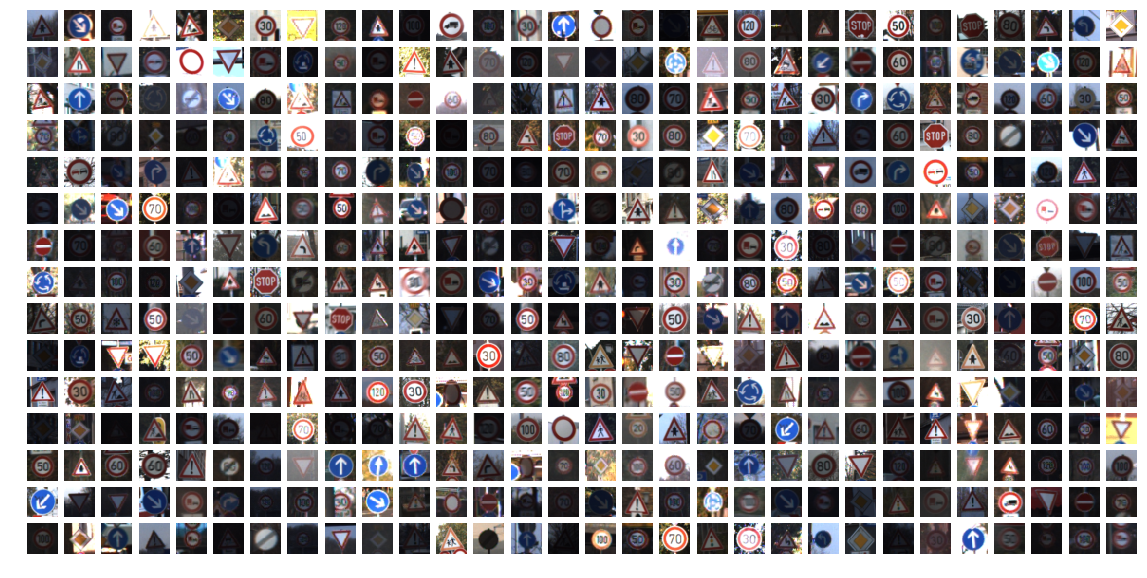

In [15]:
#PLOT 350 RANDOM IMAGES from training set
show_images(X_train, len(X_train), len(X_train), 
            images_per_row = 30, images_per_col = 15, 
            H = 20, W = 10)

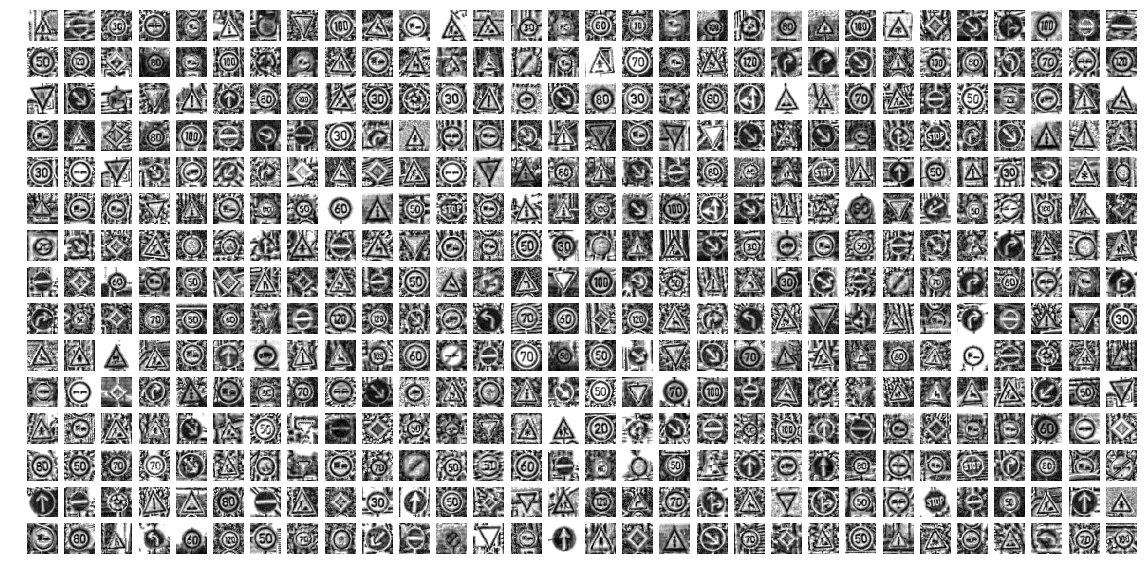

In [16]:
#PLOT 350 RANDOM IMAGES from PREPROCESSED training set
i = np.copy(X_train_preprocessed)

show_images(i, len(i), len(i), images_per_row = 30, images_per_col = 15, 
            H = 20, W = 10, its_gray = True)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


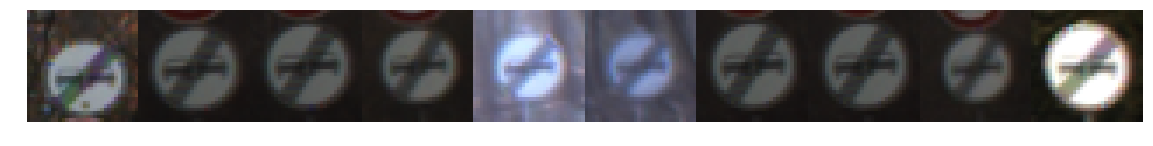

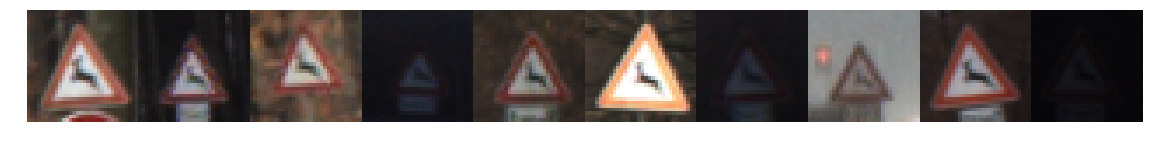

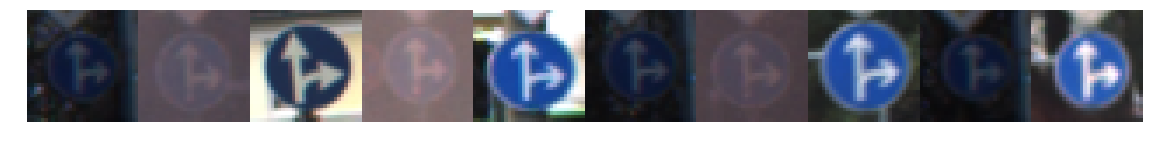

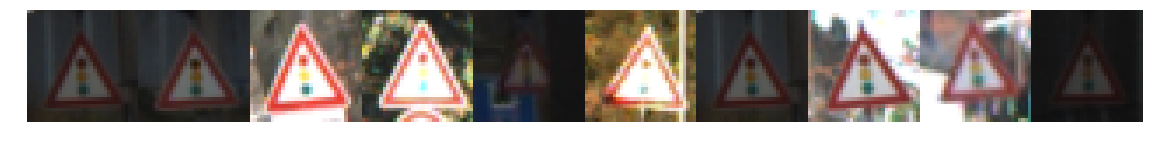

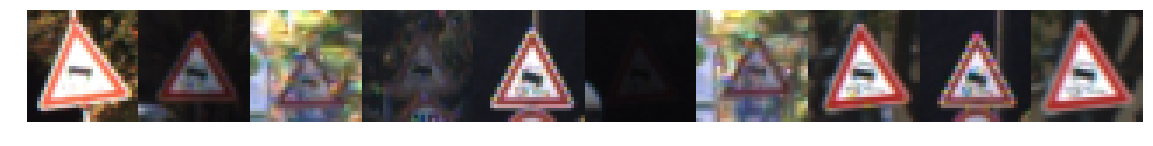

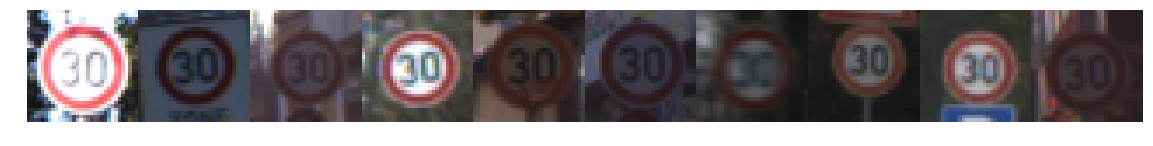

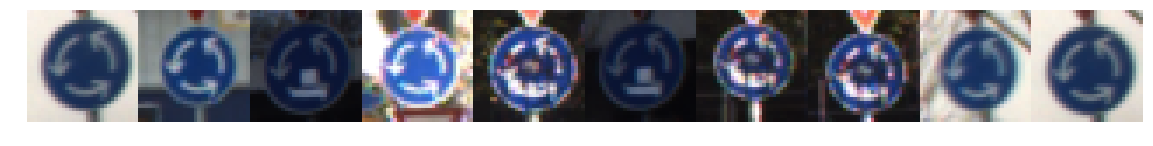

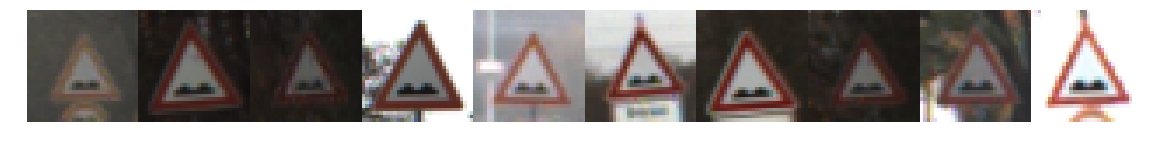

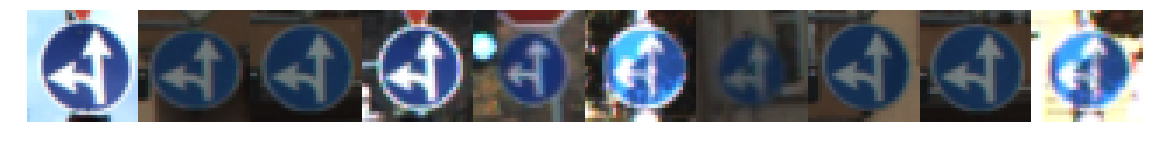

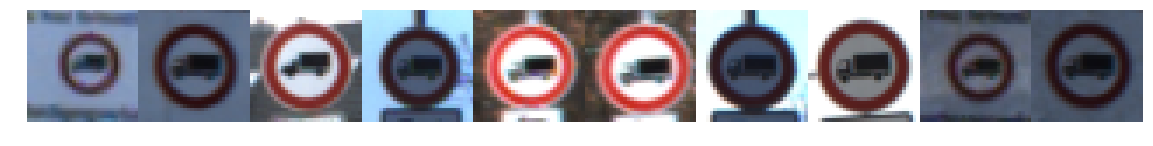

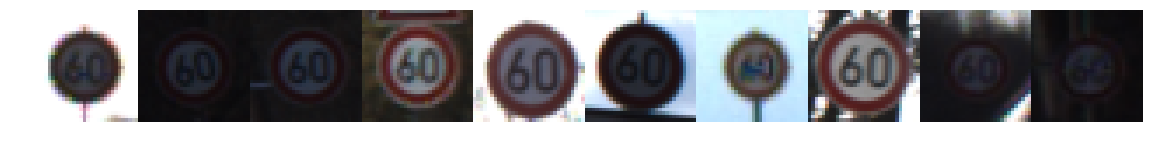

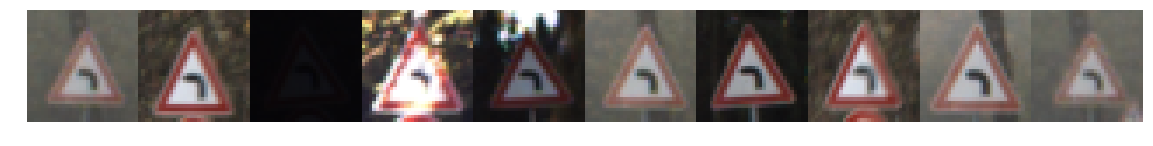

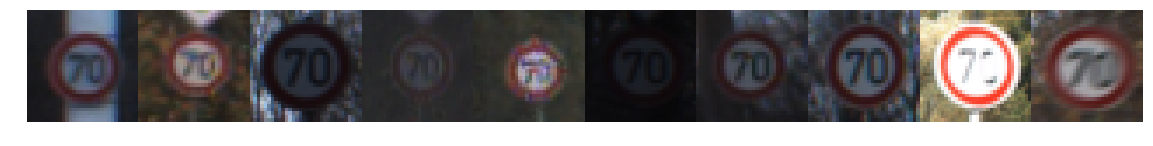

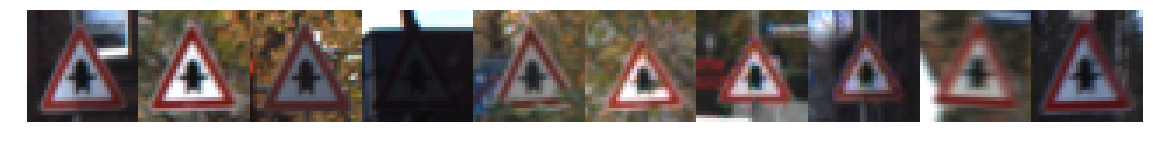

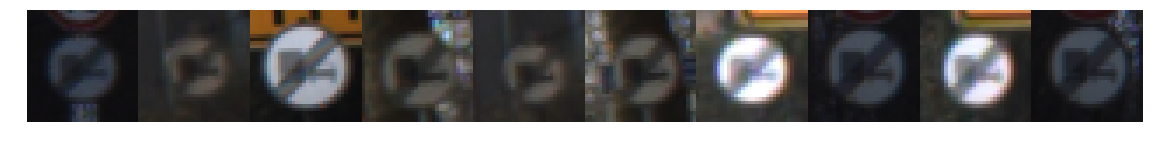

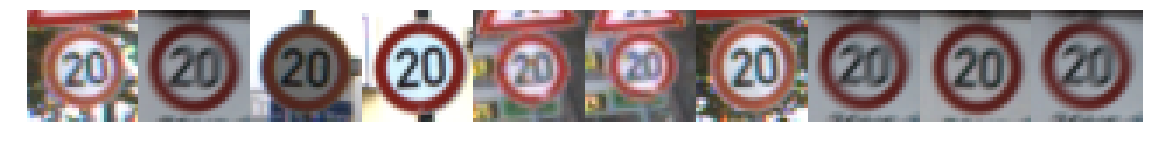

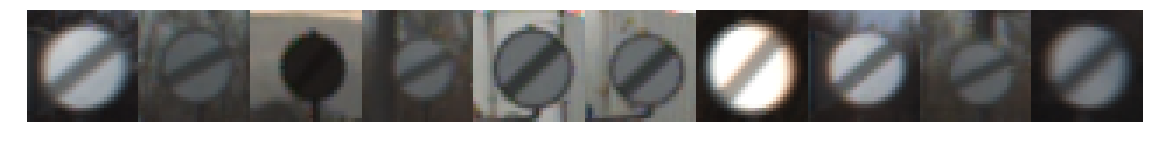

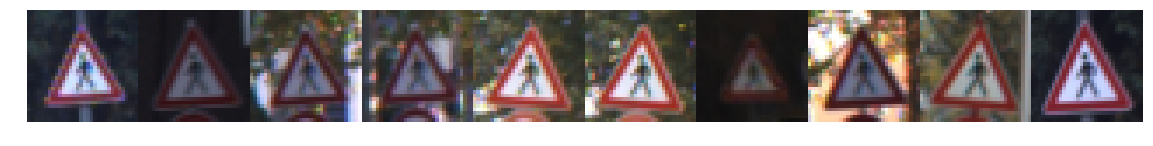

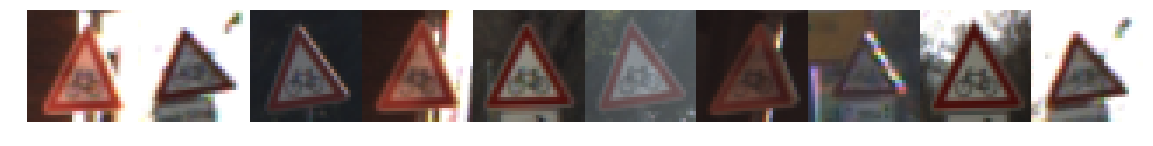

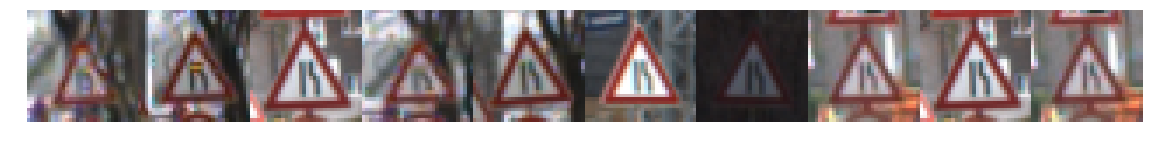

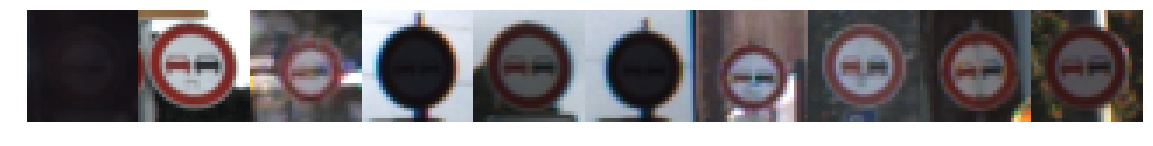

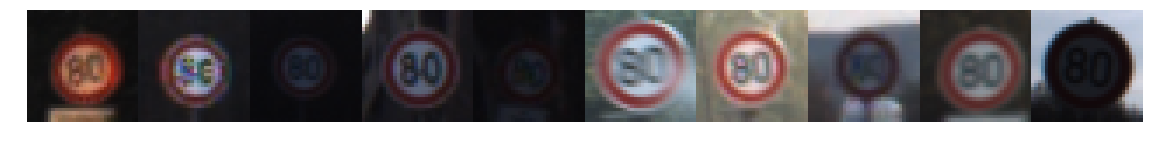

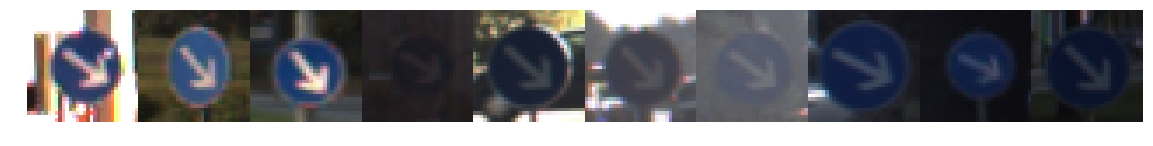

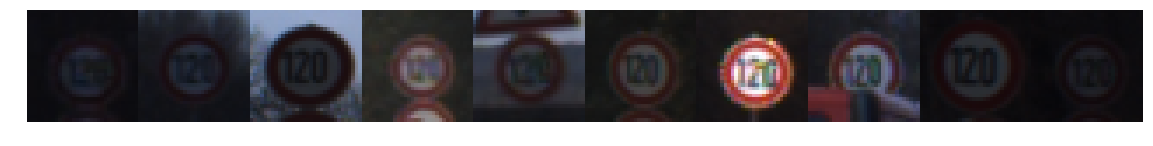

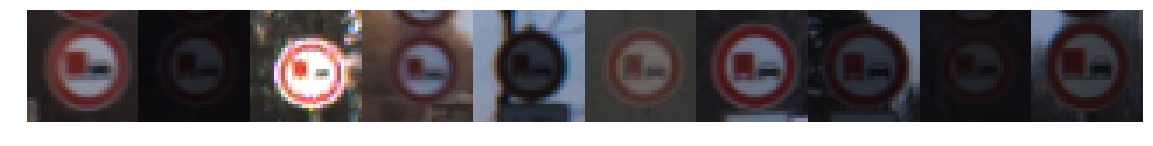

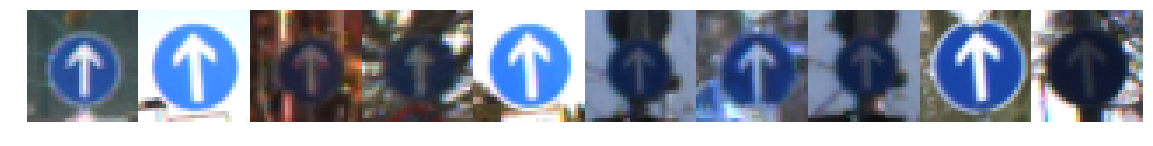

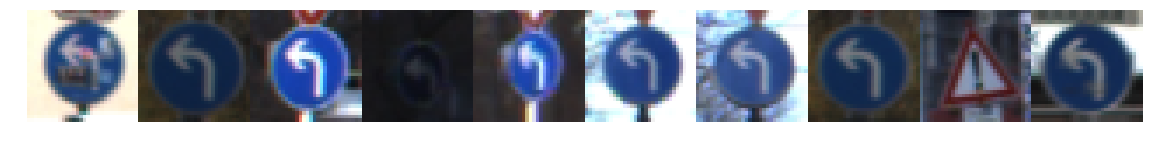

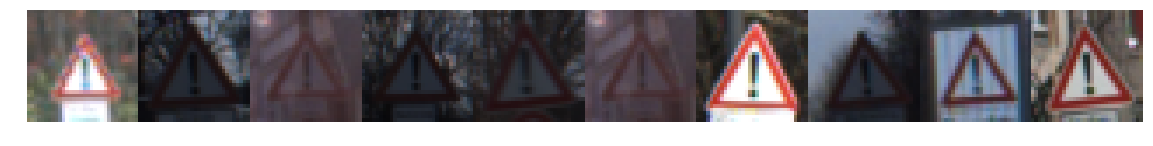

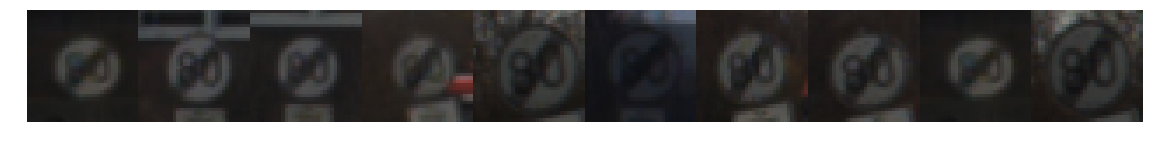

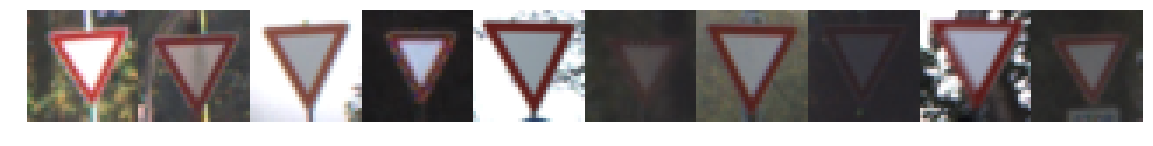

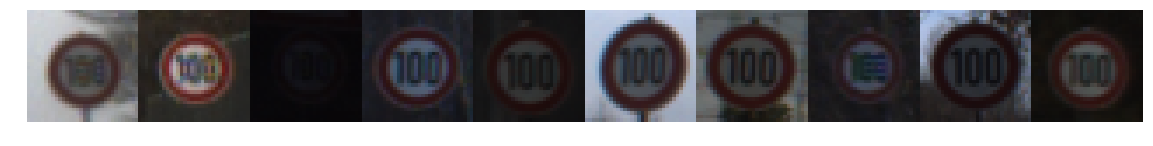

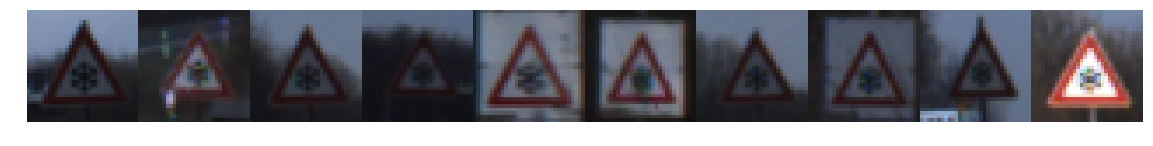

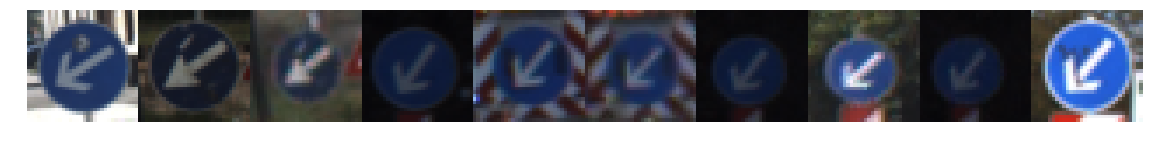

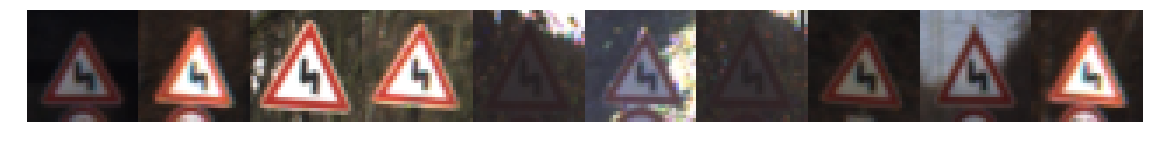

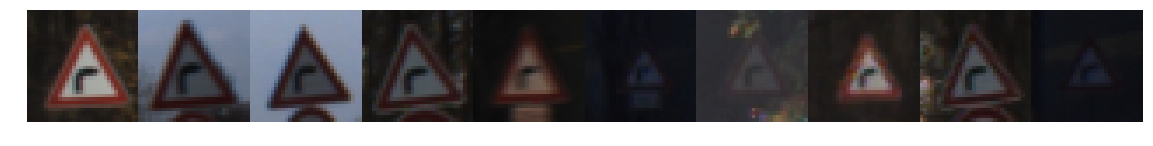

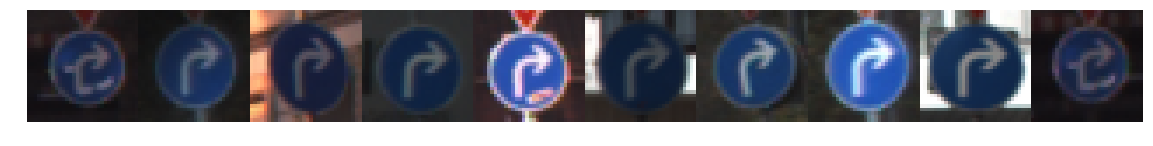

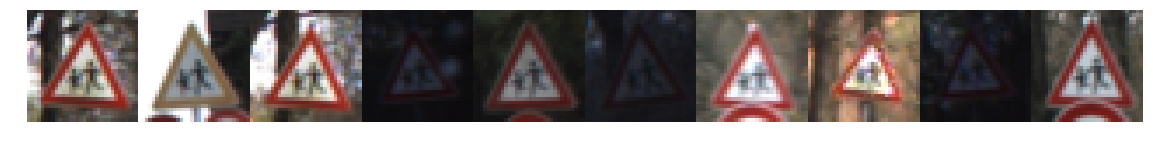

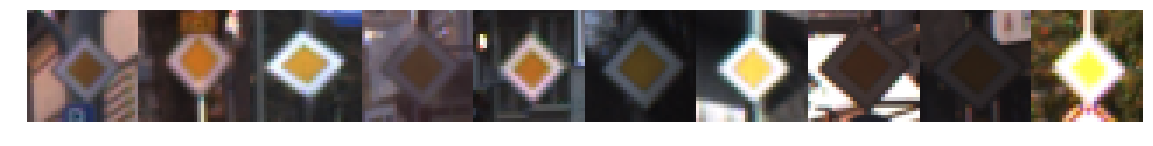

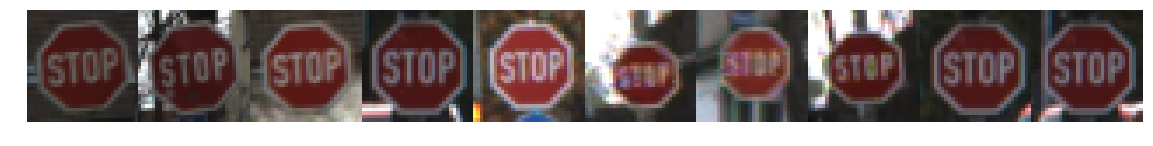

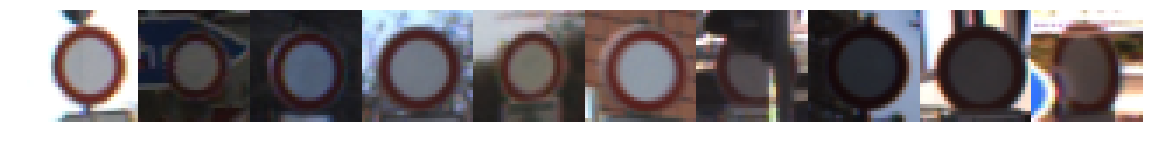

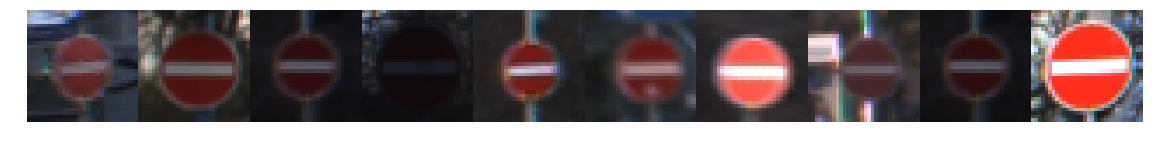

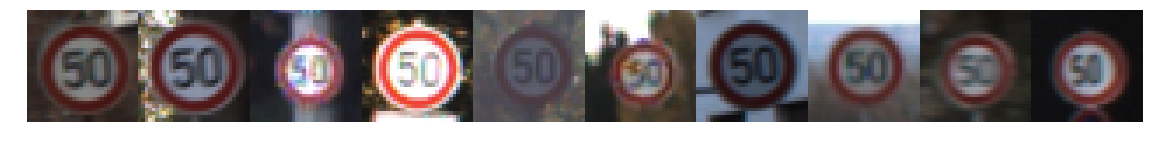

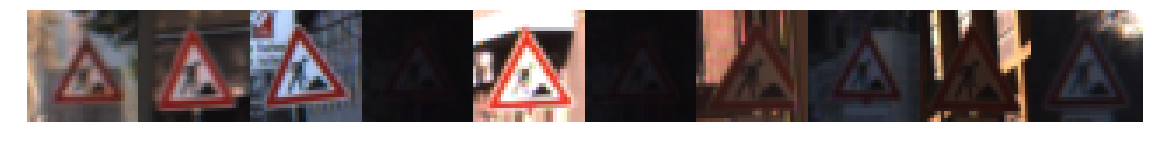

In [17]:
#PLOT 10 RANDOM IMAGES each per classification
for n in classes_lineup:
    show_images(X_train, running_counts[n], count_per_class[n], 
                images_per_row = 10, images_per_col = 1, H = 20, W = 20)

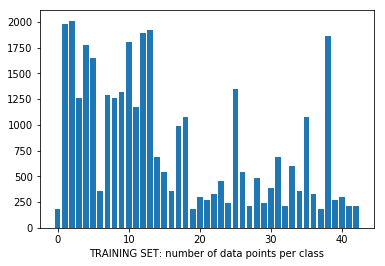

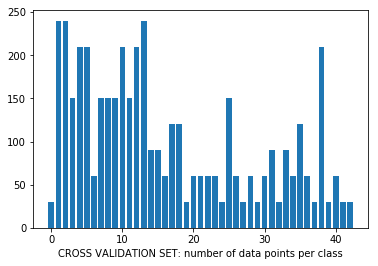

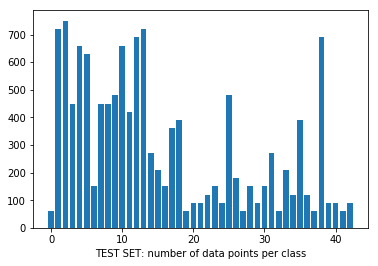

In [18]:
#PLOT HISTOGRAM OF EACH DATA SET
plot_histogram(y_train, name = "TRAINING SET: number of data points per class")
plot_histogram(y_valid, name = "CROSS VALIDATION SET: number of data points per class")
plot_histogram(y_test, name = "TEST SET: number of data points per class")

In [13]:
######################################
#      NETWORK ARCHITECTURE         #
####################################

In [14]:
def convolution(x, W, b, s = 1, with_relu = True, with_maxpool = False):
    result = tf.nn.conv2d(x, W, strides = [1, s, s, 1], padding = 'SAME')
    result = tf.nn.bias_add( result, b)
    if with_relu:
        result = tf.nn.relu(result)
    if with_maxpool:
        result = tf.nn.max_pool( result, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return result

def fully_connected(x, W, b, keep_prob, do_flatten = True, with_relu = True):
    if do_flatten:
        x = flatten(x)
    result = tf.add(tf.matmul(x, W), b) 
    if with_relu:
        result = tf.nn.relu(result)
    result = tf.nn.dropout(result, keep_prob)
    return result
    
def network(x, W, b, dropout_prob):
    r = convolution(x, W['wc1'], b['bc1'], with_maxpool = True)
    r = convolution(r, W['wc2'], b['bc2'], with_maxpool = True)
    r = fully_connected(r, W['wf1'], b['bf1'], keep_prob = dropout_prob)
    r = fully_connected(r, W['wf2'], b['bf2'], keep_prob = dropout_prob, do_flatten = False, with_relu = False)
    return r 

In [15]:
output_size = 43 #number of classifiers/labels - n_classes
c = 1         
fs1 = 5       
fs2 = 5        
depth1 = 64  #32
depth2 = 32  #64
fc_out = 256 #1024


weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(fs1, fs1, c, depth1), mean = 0, stddev = 0.1)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(fs2, fs2, depth1, depth2), mean = 0, stddev = 0.1)),
    'wf1': tf.Variable(tf.truncated_normal(shape=(8*8*depth2, fc_out), mean = 0, stddev = 0.1)),
    'wf2': tf.Variable(tf.truncated_normal(shape=(fc_out, output_size), mean = 0, stddev = 0.1))  
}

biases = {
    'bc1': tf.Variable(tf.zeros(depth1)),
    'bc2': tf.Variable(tf.zeros(depth2)),
    'bf1': tf.Variable(tf.zeros(fc_out)),
    'bf2': tf.Variable(tf.zeros(output_size))
}

#CONV1_INPUT: 32x32x1 OUTPUT:32x32xdepth1 MAXPOOLOUTPUT: 16x16xdepth1
#CONV2_INPUT: 16x16xdepth1 OUTPUT: 16x16xdepth2 MAXPOOLOUTPUT: 8x8xdepth2
#FC1_INPUT: 8x8xdepth2 OUTPUT: 8x8xdepth2
#FC1_INPUT: 8x8xdepth2 OUTPUT: n_classes

In [16]:
################################################
#      NETWORK TRAINING     AND TESTING       #
##############################################

In [17]:
LEARNING_RATE = 0.00005

EPOCHS = 180     
BATCH_SIZE = 256 #512

IMAGE_SIZE = 32
NUMBER_OF_CLASSES = 43           #n_classes
NUMBER_OF_TRAINING_DATA = 34799  #len(y_train)

LR = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 1))
y = tf.placeholder(tf.int32, shape = (None))
one_hot_y = tf.one_hot(y, NUMBER_OF_CLASSES)
keep_prob = tf.placeholder(tf.float32) 

saver = tf.train.Saver()

logits = network(x, weights, biases, dropout_prob = keep_prob)

CROSS_ENTROPY_OPERATION = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
LOSS_OPERATION = tf.reduce_mean(CROSS_ENTROPY_OPERATION)
OPTIMIZER_OPERATION = tf.train.AdamOptimizer(learning_rate = LR)
TRAINING_OPERATION = OPTIMIZER_OPERATION.minimize(LOSS_OPERATION)
INFERENCE_OPERATION = tf.argmax(logits, 1)
CORRECT_PREDICTION_OPERATION = tf.equal(INFERENCE_OPERATION, tf.argmax(one_hot_y, 1))
ACCURACY_OPERATION = tf.reduce_mean(tf.cast(CORRECT_PREDICTION_OPERATION, tf.float32))

In [18]:
def get_batch(X_data, y_data, start, BATCH_SIZE):
    end = start + BATCH_SIZE
    return X_data[start:end], y_data[start:end]

def evaluate(X_data, y_data):
    
    total_accuracy = 0
    total_samples = len(X_data)
    sess = tf.get_default_session()
    
    for start in range(0, total_samples, BATCH_SIZE):        
        batch_x, batch_y = get_batch(X_data, y_data, start, BATCH_SIZE) 
        params = {x: batch_x, y: batch_y, keep_prob: 1.0}
        accuracy = sess.run(ACCURACY_OPERATION, feed_dict= params)
        total_accuracy += (accuracy * len(batch_x))
    
    return total_cost/ total_samples, total_accuracy / total_samples

In [19]:
# TRAIN THE MODEL

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    for epoch in range(EPOCHS):
        
        X_data, y_data = shuffle(X_train_preprocessed, y_train)
        
        for start in range(0, NUMBER_OF_TRAINING_DATA, BATCH_SIZE):
            
            batch_x, batch_y = get_batch(X_data, y_data, start, BATCH_SIZE)
            params = {x: batch_x, y: batch_y, keep_prob: 0.75, LR: LEARNING_RATE}
            _, loss = sess.run([TRAINING_OPERATION, LOSS_OPRATION], feed_dict = params)
            
        validation_accuracy, validation_cost = evaluate(X_valid_preprocessed, y_valid)
        
        print("{:3d}".format(epoch), "VA = {:.3f}".format(validation_accuracy), 
              "last training cost = {:.3f}".format(loss))
        
    saver.save(sess, './model')
    print("Model saved")

  0 VA = 0.159 cost = 3.509865
  1 VA = 0.345 cost = 2.983721
  2 VA = 0.466 cost = 2.573606
  3 VA = 0.539 cost = 2.439859
  4 VA = 0.611 cost = 2.019744
  5 VA = 0.669 cost = 1.819499
  6 VA = 0.709 cost = 1.808188
  7 VA = 0.745 cost = 1.705296
  8 VA = 0.753 cost = 1.440065
  9 VA = 0.780 cost = 1.349036
 10 VA = 0.797 cost = 1.452468
 11 VA = 0.811 cost = 1.323506
 12 VA = 0.817 cost = 1.190047
 13 VA = 0.828 cost = 1.278049
 14 VA = 0.839 cost = 1.063583
 15 VA = 0.846 cost = 1.317498
 16 VA = 0.855 cost = 1.058808
 17 VA = 0.861 cost = 1.183124
 18 VA = 0.865 cost = 0.948065
 19 VA = 0.868 cost = 1.077286
 20 VA = 0.875 cost = 1.035328
 21 VA = 0.879 cost = 1.009082
 22 VA = 0.882 cost = 0.990742
 23 VA = 0.885 cost = 0.922477
 24 VA = 0.889 cost = 1.035396
 25 VA = 0.893 cost = 0.976457
 26 VA = 0.896 cost = 0.839368
 27 VA = 0.895 cost = 0.979501
 28 VA = 0.900 cost = 0.790099
 29 VA = 0.904 cost = 0.728587
 30 VA = 0.905 cost = 0.786695
 31 VA = 0.905 cost = 0.770512
 32 VA =

In [20]:
# EVALUATE USING TEST DATA 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.950


In [21]:
###################################
#   Test the model on New Images #
#################################

In [30]:
# LOAD THE NEW IMAGES FROM THE INTERNET TO A NUMPY ARRAY

path = 'data/'
image_name = ['0-20speed','1-30speed',
              '12-priority-road','13-yield',
              '14-stop','17-no-entry',
              '18-general-caution','3-60speed',
              '36-go-straight-right', 
              '40-roundabout-mandatory']

image_list = []

for name in image_name:
    img = imread(path + name + '.png')
    img = imresize(img, (32, 32))
    image_list.append(img)

own_set_x = np.array(image_list)
own_set_x = preprocess(own_set_x)
own_set_x = reshape(own_set_x)
own_set_y = np.array([0, 1, 12, 13, 14, 17, 18, 3, 36, 40])
print(own_set_x.shape, own_set_y.shape)

(10, 32, 32, 1) (10,)


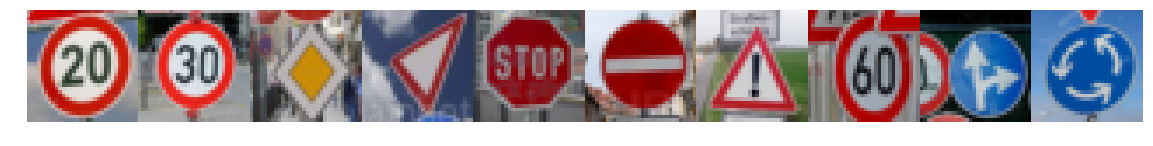

In [29]:
#show selected image from internet 

number_of_images = len(image_list)
figure, axis = plt.subplots(1, number_of_images, figsize=(20, 20))
figure.subplots_adjust(hspace = .2, wspace=.001)
axis = axis.ravel()
    
for i in range(number_of_images):     
    image = image_list[i]
    axis[i].axis('off')
    axis[i].imshow(image)

In [31]:
#CHECK HOW OUR SELECTED IMAGES FAIRED, AND ITS TOP 5 PREDICTION BASED on built-in top_k function 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    OUT = sess.run(tf.argmax(logits, 1), feed_dict={x: own_set_x, y: own_set_y, keep_prob: 1.0})
    print("", OUT, "<-predictions")
    print("", own_set_y, "<-actual")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    OUT = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: own_set_x, y: own_set_y, keep_prob: 1.0})
    print(OUT[1].T)
    print("(top  5 predictions above) for each image")
    
print()    
print("probability for top 5 predictions for each image:")
for i in range(len(own_set_y)):
    print(i, OUT[0][i].T)


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(own_set_x, own_set_y )
    print("Test Accuracy = {:.3f}".format(test_accuracy))

 [ 0  1 12 13 14 17 18  3 36 40] <-predictions
 [ 0  1 12 13 14 17 18  3 36 40] <-actual
[[ 0  1 12 13 14 17 18  3 36 40]
 [ 1  2 35  5  3 33 26  6 28 11]
 [ 6  6 25 12  8  9 27  1 38 16]
 [29 38 26 33  1 14 24 34 35  7]
 [34  0 40  2  4 40 36 11 12 17]]
(top  5 predictions above) for each image

probability for top 5 predictions for each image:
0 [  9.32689548e-01   5.41089848e-02   1.31279845e-02   2.31403465e-05
   1.45926260e-05]
1 [  9.99820888e-01   1.76206828e-04   1.00970851e-06   9.46819682e-07
   7.42028533e-07]
2 [  1.00000000e+00   4.18683488e-09   7.02348402e-10   3.46118190e-10
   3.12163795e-10]
3 [  1.00000000e+00   3.13466253e-10   2.64161998e-10   6.51305052e-11
   3.08685751e-11]
4 [  9.99993563e-01   1.72575687e-06   1.65607423e-06   1.56471299e-06
   9.00445173e-07]
5 [  1.00000000e+00   5.89572613e-10   1.53520793e-10   3.20257085e-11
   2.61226735e-11]
6 [  1.00000000e+00   2.20382557e-09   8.86765050e-10   2.57165150e-10
   1.40842324e-10]
7 [  9.99720633e-01   